In [1]:
!pip install tensorflow keras matplotlib tqdm scikit-learn

    100% |████████████████████████████████| 327kB 2.5MB/s 
    100% |████████████████████████████████| 61kB 6.1MB/s 


### Numpy vs Tensorflow 

In [0]:
import numpy as np

A = np.random.random((5000, 5000))
B = np.random.random((5000, 5000))

In [3]:
%%time
result_np = A @ B

CPU times: user 14.6 s, sys: 296 ms, total: 14.8 s
Wall time: 7.58 s


In [0]:
import tensorflow as tf
s = tf.InteractiveSession()

# задаем входы для матриц
A_input = tf.placeholder('float32', shape=(5000, 5000), name='A')
B_input = tf.placeholder('float32', shape=(5000, 5000), name='B')

output = A_input @ B_input

In [5]:
output

<tf.Tensor 'matmul:0' shape=(5000, 5000) dtype=float32>

In [6]:
%%time
result_tf = output.eval({A_input: A,
                         B_input: B}, session=s)

CPU times: user 4.09 s, sys: 271 ms, total: 4.36 s
Wall time: 2.29 s


In [7]:
np.allclose(result_np, result_tf)

True

In [0]:
v1 = tf.placeholder('float32', shape=(None, ), name='v1')
v2 = tf.placeholder('float32', shape=(None, ), name='v2')

mse = tf.reduce_mean((v1 - v2) ** 2)

compute_mse = lambda vector1, vector2: mse.eval({v1: vector1, v2: vector2})

In [10]:
mse

<tf.Tensor 'Mean:0' shape=() dtype=float32>

In [0]:
from sklearn.metrics import mean_squared_error

for n in [1,5,10,10**3]:
    
    elems = [np.arange(n),np.arange(n,0,-1), np.zeros(n),
             np.ones(n),np.random.random(n),np.random.randint(100,size=n)]
    
    for el in elems:
        for el_2 in elems:
            true_mse = np.array(mean_squared_error(el,el_2))
            my_mse = compute_mse(el, el_2)
            if not np.allclose(true_mse,my_mse):
                print(n, "Что-то не так", true_mse, my_mse)

## Переменные

In [0]:
# заводим переменную
shared_vector_1 = tf.Variable(initial_value=np.ones(5))

In [13]:
#инициализируем в графе
s.run(tf.global_variables_initializer())

print("initial value", s.run(shared_vector_1))

initial value [1. 1. 1. 1. 1.]


In [14]:
#меняем значение
s.run(shared_vector_1.assign(np.arange(5)))
print ("new value", s.run(shared_vector_1))

new value [0. 1. 2. 3. 4.]


# tf.gradients

In [0]:
my_scalar = tf.placeholder('float32')

scalar_squared = my_scalar ** 2

derivative = tf.gradients(scalar_squared, my_scalar)[0]

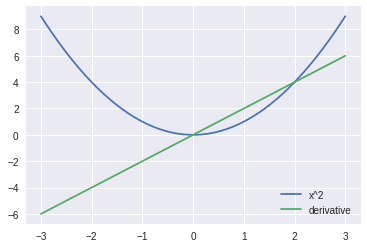

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(-3,3)
x_squared, x_squared_der = s.run([scalar_squared,derivative],
                                 {my_scalar:x})

plt.plot(x, x_squared,label="x^2")
plt.plot(x, x_squared_der, label="derivative")
plt.legend()

In [0]:
my_vector = tf.placeholder('float32',[None])

weird_psychotic_function = tf.reduce_mean((my_vector + my_scalar) ** (1 + tf.nn.moments(my_vector, [0])[1]) + 1./ tf.atan(my_scalar))/(my_scalar ** 2 + 1) + 0.01 * tf.sin(2 * my_scalar ** 1.5) * (tf.reduce_sum(my_vector) * my_scalar ** 2) * tf.exp((my_scalar-4) ** 2) / (1 + tf.exp((my_scalar - 4) ** 2)) * (1. - (tf.exp(-(my_scalar - 4) ** 2)) / (1 + tf.exp(-(my_scalar - 4) ** 2))) ** 2


der_by_scalar, der_by_vector = tf.gradients(weird_psychotic_function, 
                                            [my_scalar, my_vector])

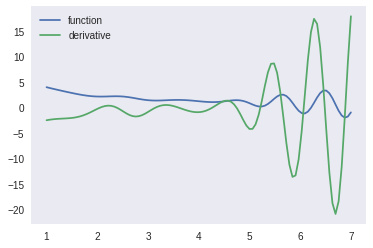

In [18]:
#Plotting your derivative
scalar_space = np.linspace(1,7,100)

y = [s.run(weird_psychotic_function,{my_scalar:x,my_vector:[1,2,3]})
     for x in scalar_space]

plt.plot(scalar_space,y,label='function')

y_der_by_scalar = [s.run(der_by_scalar,{my_scalar:x,my_vector:[1,2,3]})
     for x in scalar_space]

plt.plot(scalar_space,y_der_by_scalar,label='derivative')
plt.grid();plt.legend()


### Оптимизаторы


In [0]:
y_guess = tf.Variable(np.zeros(2,dtype='float32'))
y_true = tf.range(1,3,dtype='float32')

loss = tf.reduce_mean((y_guess - y_true + tf.random_normal([2]))**2) 

optimizer = tf.train.MomentumOptimizer(0.01, 0.9).minimize(loss, var_list=y_guess)

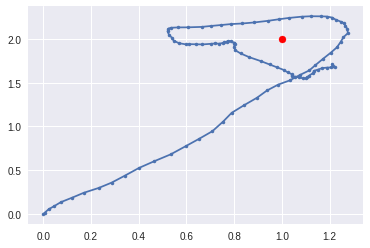

In [20]:
from IPython.display import clear_output

s.run(tf.global_variables_initializer())

guesses = [s.run(y_guess)]

for _ in range(100):
    s.run(optimizer)
    guesses.append(s.run(y_guess))
    
    clear_output(True)
    plt.plot(*zip(*guesses),marker='.')
    plt.scatter(*s.run(y_true),c='red')
    plt.show()

## Логистическая регрессия

In [21]:
from sklearn.datasets import load_digits
mnist = load_digits(2)

X, y = mnist.data, mnist.target

X[0], y[0]

(array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
        15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
        12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
         0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
        10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.]), 0)

In [0]:
weights = tf.Variable(np.zeros(X.shape[1], dtype='float32'))
input_X = tf.placeholder('float32', shape=(None, ) + X.shape[1:])
input_y = tf.placeholder('float32', shape=(None, ))

In [51]:
tf.reduce_sum(input_X * weights, axis=1)

<tf.Tensor 'Sum_10:0' shape=(?,) dtype=float32>

In [0]:
def sigmoid(x):
  return 1.0 / (1.0 + tf.exp(-x))

predicted_y = sigmoid(tf.reduce_sum(input_X * weights, axis=1))
loss = -tf.reduce_sum(input_y * tf.log(predicted_y + 1e-7) + 
                      (1 - input_y) * tf.log(1 - predicted_y + 1e-7))

optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-3).minimize(loss, var_list=weights)

In [0]:
train_function = lambda X_b, y_b: s.run([loss, optimizer], {input_X: X_b, 
                                                            input_y: y_b})[0]
predict_function = lambda X_b: s.run(predicted_y, {input_X: X_b})

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [0]:
s.run(tf.global_variables_initializer())

In [56]:
s.run(weights)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

loss at iter 0:187.1497
train auc: 0.9999451032059727
test auc: 1.0
loss at iter 1:1.6185
train auc: 1.0
test auc: 1.0
loss at iter 2:0.8274
train auc: 1.0
test auc: 1.0
loss at iter 3:0.5193
train auc: 1.0
test auc: 1.0
loss at iter 4:0.3777
train auc: 1.0
test auc: 1.0
loss at iter 5:0.2967
train auc: 1.0
test auc: 1.0
loss at iter 6:0.2437
train auc: 1.0
test auc: 1.0
loss at iter 7:0.2066
train auc: 1.0
test auc: 1.0
loss at iter 8:0.1791
train auc: 1.0
test auc: 1.0
loss at iter 9:0.1580
train auc: 1.0
test auc: 1.0
loss at iter 10:0.1413
train auc: 1.0
test auc: 1.0
loss at iter 11:0.1278
train auc: 1.0
test auc: 1.0
loss at iter 12:0.1166
train auc: 1.0
test auc: 1.0
loss at iter 13:0.1072
train auc: 1.0
test auc: 1.0
loss at iter 14:0.0992
train auc: 1.0
test auc: 1.0
loss at iter 15:0.0923
train auc: 1.0
test auc: 1.0
loss at iter 16:0.0863
train auc: 1.0
test auc: 1.0
loss at iter 17:0.0810
train auc: 1.0
test auc: 1.0
loss at iter 18:0.0764
train auc: 1.0
test auc: 1.0
loss 

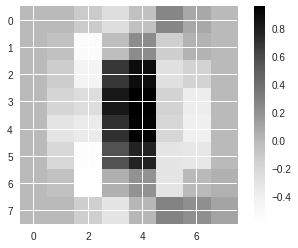

In [57]:
from sklearn.metrics import roc_auc_score

for i in range(100):
    loss_i = train_function(X_train, y_train)
    
    print ("loss at iter %i:%.4f"%(i,loss_i))
    
    print ("train auc:", roc_auc_score(y_train, predict_function(X_train)))
    print ("test auc:", roc_auc_score(y_test, predict_function(X_test)))

    
print ("resulting weights:")
plt.imshow(weights.eval().reshape(8,-1))
plt.colorbar()

## Нейронная сеть

In [0]:
class DenseNN:
    def __init__(self):
        self.training  = tf.placeholder_with_default(True, shape=())
        self.dense_1 = tf.layers.Dense(10, activation=tf.nn.relu)
        self.dense_2 = tf.layers.Dense(10, activation=None)
        
    def __call__(self, X):
        return self.dense_2(tf.layers.Dropout()(self.dense_1(X), training=self.training))

In [0]:
nn = DenseNN()

In [60]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

# np.array
train_data = mnist.train.images 
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images 
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


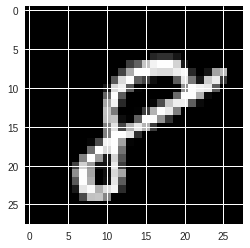

In [61]:
plt.imshow(train_data[-1].reshape((28, 28)), cmap='gray')

In [0]:
input_X = tf.placeholder('float32', shape=(None, ) + train_data.shape[1:])
input_y = tf.placeholder('int32', shape=(None, ))

nn = DenseNN()

# хотим получать не вероятности, а значения до softmax
logits = nn(input_X)

loss = tf.losses.sparse_softmax_cross_entropy(input_y, logits)

predictions = {"classes": tf.argmax(input=logits, axis=1),
               "probabilities": tf.nn.softmax(logits, name="softmax_tensor")}

In [0]:
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss=loss,
                              global_step=tf.train.get_global_step())

In [0]:
s.run(tf.global_variables_initializer())

In [0]:
from tqdm import tqdm_notebook

In [67]:
batch_size = 1024
idx = np.arange(len(train_data))
for epoch in range(10):
    np.random.shuffle(idx)
    train_loss = 0
    cnt = 0
    for i in range(0, len(train_data), batch_size):
        cur_idx = idx[i: i + batch_size]
        cur_loss = s.run([loss, train_op], {input_X: train_data[idx], 
                                            input_y: train_labels[idx],
                                            nn.training: True})[0]
        train_loss += cur_loss
        cnt += 1
        
        if i % 64 == 63:
            print(train_loss / cnt)
        
    
        
    eval_loss = s.run(loss, {input_X: eval_data, 
                             input_y: eval_labels,
                             nn.training: False})
    classes = s.run(predictions['classes'], {input_X: eval_data, 
                                             input_y: eval_labels,
                                             nn.training: False})
    print(np.mean(classes == eval_labels))
    
    print(eval_loss)

0.5716
1.5617253
0.7056
1.1873994
0.8532
0.9502544
0.872
0.8139947
0.8791
0.72853214
0.883
0.6697913
0.888
0.62175745
0.8887
0.5834291
0.8878
0.55676603
0.8873
0.53498465


# Keras

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [0]:
model = Sequential()
model.add(Dense(input_shape=train_data.shape[1:], units=10, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

In [0]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [72]:
model.fit(train_data, train_labels, 
          batch_size=64, epochs=10, validation_data=(eval_data, eval_labels))

Train on 55000 samples, validate on 10000 samples
Epoch 1/10
55000/55000 [==============================] - 2s 31us/step - loss: 0.6089 - acc: 0.8293 - val_loss: 0.3295 - val_acc: 0.9091
Epoch 2/10
55000/55000 [==============================] - 2s 30us/step - loss: 0.3147 - acc: 0.9108 - val_loss: 0.2884 - val_acc: 0.9177
Epoch 3/10
55000/55000 [==============================] - 2s 31us/step - loss: 0.2840 - acc: 0.9192 - val_loss: 0.2736 - val_acc: 0.9243
Epoch 4/10
55000/55000 [==============================] - 2s 30us/step - loss: 0.2688 - acc: 0.9238 - val_loss: 0.2611 - val_acc: 0.9273
Epoch 5/10
55000/55000 [==============================] - 2s 32us/step - loss: 0.2597 - acc: 0.9270 - val_loss: 0.2617 - val_acc: 0.9244
Epoch 6/10
55000/55000 [==============================] - 2s 31us/step - loss: 0.2521 - acc: 0.9298 - val_loss: 0.2614 - val_acc: 0.9267
Epoch 7/10
 3648/55000 [>.............................] - ETA: 1s - loss: 0.2299 - acc: 0.9350

55000/55000 [==============================] - 2s 31us/step - loss: 0.2462 - acc: 0.9312 - val_loss: 0.2515 - val_acc: 0.9284
Epoch 8/10
55000/55000 [==============================] - 2s 31us/step - loss: 0.2419 - acc: 0.9325 - val_loss: 0.2517 - val_acc: 0.9288
Epoch 9/10
55000/55000 [==============================] - 2s 31us/step - loss: 0.2366 - acc: 0.9335 - val_loss: 0.2517 - val_acc: 0.9288
Epoch 10/10
55000/55000 [==============================] - 2s 32us/step - loss: 0.2332 - acc: 0.9346 - val_loss: 0.2495 - val_acc: 0.9282


# Zoo 

In [0]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

from matplotlib import pyplot as plt
%matplotlib inline

In [74]:
resnet = ResNet50()

102858752/102853048 [==============================] - 7s 0us/step


In [76]:
resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [0]:
!wget -q "https://s1.1zoom.ru/big0/607/359313-sepik.jpg" -O dog.jpg

40960/35363 [==================================] - 0s 3us/step
Predicted: [('n02089867', 'Walker_hound', 0.6062931), ('n02088364', 'beagle', 0.2357255), ('n02088238', 'basset', 0.11335999)]


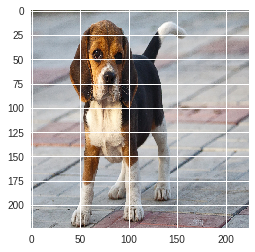

In [77]:
dog = image.load_img('./dog.jpg', target_size=(224, 224))
plt.imshow(dog)

img = image.img_to_array(dog)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

preds = resnet.predict(img)
print('Predicted:', decode_predictions(preds, top=3)[0])


In [78]:
resnet.layers[-1].trainable

True

## тексты

In [0]:
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import SimpleRNN

In [81]:
num_words = 1000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)

17465344/17464789 [==============================] - 4s 0us/step


In [0]:
max_review_length = 100
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

In [83]:
model = Sequential()
model.add(Embedding(num_words, 16, input_length=max_review_length))
model.add(SimpleRNN(10))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 16)           16000     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 10)                270       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 16,281
Trainable params: 16,281
Non-trainable params: 0
_________________________________________________________________
None
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
22272/25000 [=========================>....] - ETA: 0s - loss: 0.6827 - acc: 0.5505

25000/25000 [==============================] - 11s 453us/step - loss: 0.6810 - acc: 0.5538 - val_loss: 0.6702 - val_acc: 0.5637
Epoch 2/3
25000/25000 [==============================] - 11s 437us/step - loss: 0.6414 - acc: 0.6163 - val_loss: 0.6546 - val_acc: 0.5916
Epoch 3/3
25000/25000 [==============================] - 11s 441us/step - loss: 0.5056 - acc: 0.7597 - val_loss: 0.4952 - val_acc: 0.7756


## Домашнее задание
 * Доучите любую модель из keras.applications на бинарную классификацию на данных https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition и сделайте посылку в рейтинговую систему. В качестве отчета присылайте свой код и посылку на kaggle. 
 
 Подсказка - доучивать на датасете всю сеть целиком долго, плюс она переобучится.
 * Реализуйте сверточную нейронную сеть на данных IMDB. Сравните по качеству и времени работы с рекуррентной сетью выше при примерно равном числе параметров. В качестве отчета присылайте свой код с обучением моделей и обсуждение итогов.